# GPT-2 Research Paper | Part III

## Zero-Shot Learning: The Revolution Nobody Saw Coming

---

**Paper:** [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

**Authors:** Alec Radford, Jeffrey Wu, Rewon Child, David Luan, Dario Amodei, Ilya Sutskever (OpenAI, 2019)

---

## The Most Important Idea in Modern AI

Zero-shot learning is arguably **the most important idea** to emerge from GPT-2. It changed how we think about AI systems entirely.

Before GPT-2: "Train a model for each task."
After GPT-2: "Just ask the model to do the task."

This notebook covers:

1. **What Zero-Shot Really Means** - The precise definition
2. **The Prompting Revolution** - How to "program" with natural language
3. **Every Task GPT-2 Was Tested On** - With exact prompts and results
4. **Why Zero-Shot Works** - The deep theoretical reason
5. **The Scaling Connection** - Why bigger models are better at zero-shot
6. **Hands-On Examples** - Implementing zero-shot prompting

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle, FancyArrowPatch, Wedge, Arc
from matplotlib.patches import ConnectionPatch, Polygon, Ellipse, PathPatch
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import math
from typing import List, Dict, Tuple

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10

np.random.seed(42)
torch.manual_seed(42)

print("Ready to explore zero-shot learning!")

Ready to explore zero-shot learning!


---

## 1. What Zero-Shot Really Means

### 1.1 The Precise Definition

**Zero-shot learning** means performing a task **without any task-specific training examples**.

From the paper:

> *"We evaluate GPT-2 in the zero-shot setting on a diverse set of tasks. For each task, GPT-2 is conditioned on naturally occurring demonstrations of the task in similar style to the dataset. GPT-2 is never given any task-specific training data."*

### 1.2 The Learning Paradigms

Let's clarify the terminology:

| Paradigm | Task Examples Seen | Description |
|----------|-------------------|-------------|
| **Supervised** | Thousands-Millions | Traditional ML: train on labeled data |
| **Few-shot** | 1-100 | Learn from a handful of examples |
| **One-shot** | 1 | Learn from a single example |
| **Zero-shot** | **0** | No task-specific examples at all |

### 1.3 What GPT-2 Actually Learned

GPT-2 was trained **only** on next-word prediction:

$$\mathcal{L} = -\sum_{i} \log P(w_i | w_1, ..., w_{i-1})$$

That's it. No translation objective. No summarization objective. No QA objective.

Yet it can do all these tasks. **How?**

### 1.4 The Key Insight

From the paper:

> *"Since the supervised objective is the same as the unsupervised objective but only evaluated on a subset of the sequence, the global minimum of the unsupervised objective is also the global minimum of the supervised objective."*

**Translation:** If you're perfectly good at predicting the next word, you must implicitly understand:
- How to answer questions (to predict the answer word)
- How to translate (to predict the translated word)
- How to summarize (to predict the summary word)
- Everything else expressed in language

/tmp/ipython-input-1123952421.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


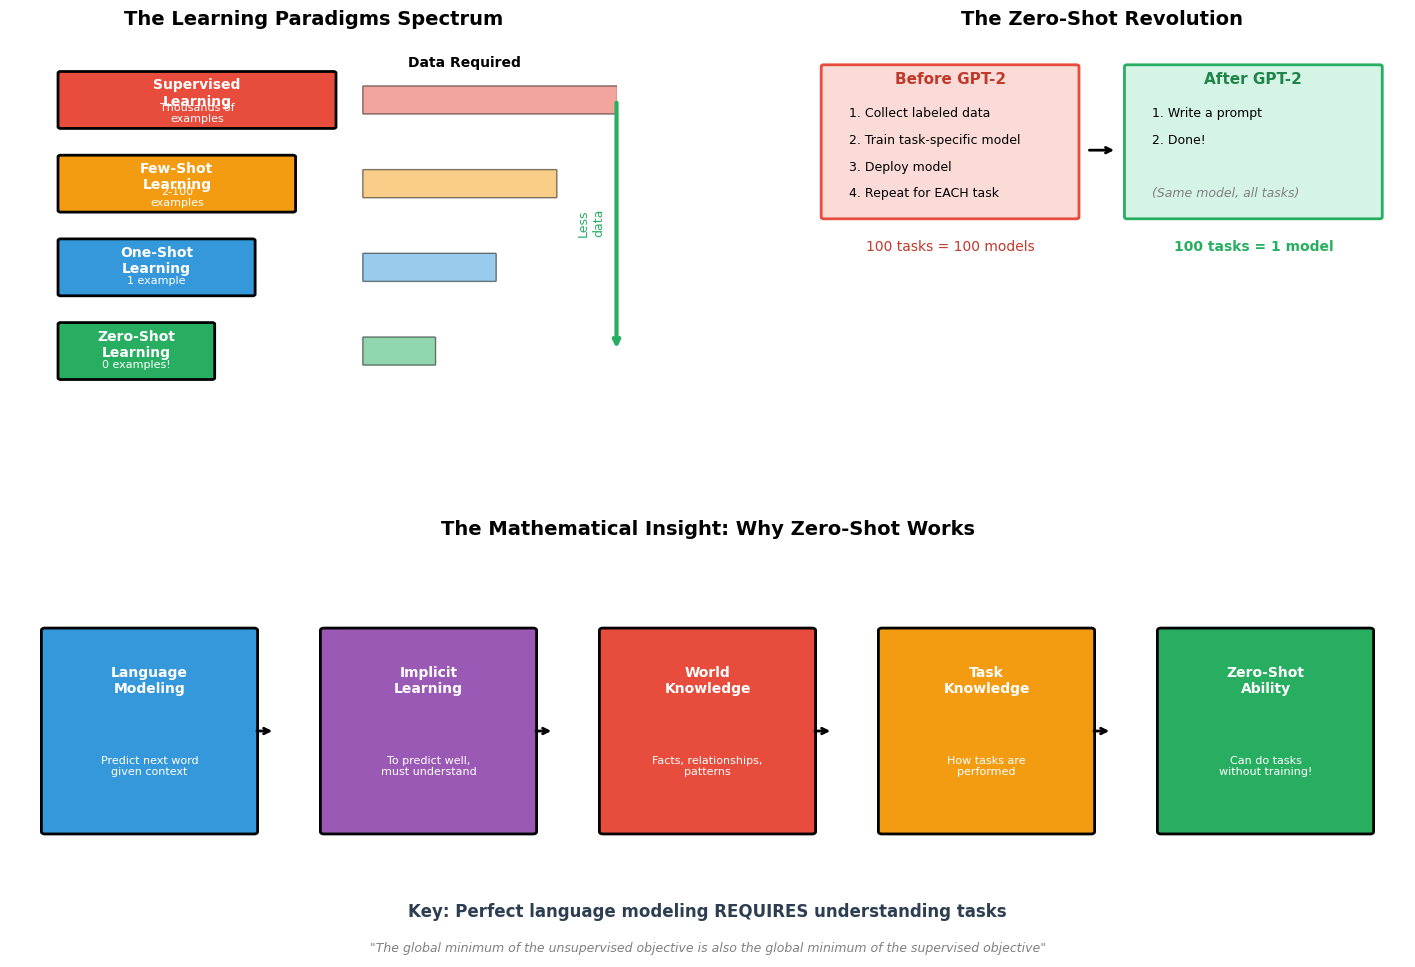

In [2]:
def visualize_learning_paradigms():
    """
    Visualize the different learning paradigms.
    """
    fig = plt.figure(figsize=(18, 12))

    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.3)

    # === TOP LEFT: Learning Paradigms ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 12)
    ax1.axis('off')
    ax1.set_title('The Learning Paradigms Spectrum', fontsize=14, fontweight='bold')

    paradigms = [
        ('Supervised\nLearning', 'Thousands of\nexamples', '#e74c3c', 10),
        ('Few-Shot\nLearning', '2-100\nexamples', '#f39c12', 7.5),
        ('One-Shot\nLearning', '1 example', '#3498db', 5),
        ('Zero-Shot\nLearning', '0 examples!', '#27ae60', 2.5),
    ]

    for i, (name, desc, color, y) in enumerate(paradigms):
        # Main box
        width = 3 + (3 - i) * 0.8  # Decreasing width
        rect = FancyBboxPatch((1, y - 0.8), width, 1.6, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax1.add_patch(rect)
        ax1.text(1 + width/2, y + 0.2, name, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')
        ax1.text(1 + width/2, y - 0.4, desc, ha='center', va='center',
                fontsize=8, color='white')

        # Data requirement indicator
        data_width = 5 - i * 1.2
        rect2 = FancyBboxPatch((7, y - 0.4), data_width, 0.8, boxstyle="round,pad=0.02",
                               facecolor=color, edgecolor='black', linewidth=1, alpha=0.5)
        ax1.add_patch(rect2)

    ax1.text(9, 11, 'Data Required', ha='center', fontsize=10, fontweight='bold')
    ax1.annotate('', xy=(12, 2.5), xytext=(12, 10),
                arrowprops=dict(arrowstyle='->', color='#27ae60', lw=3))
    ax1.text(11.5, 6, 'Less\ndata', ha='center', fontsize=9, color='#27ae60', rotation=90)

    # === TOP RIGHT: The Revolution ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 12)
    ax2.axis('off')
    ax2.set_title('The Zero-Shot Revolution', fontsize=14, fontweight='bold')

    # Before
    rect_before = FancyBboxPatch((0.5, 6.5), 5, 4.5, boxstyle="round,pad=0.05",
                                  facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
    ax2.add_patch(rect_before)
    ax2.text(3, 10.5, 'Before GPT-2', fontsize=11, ha='center', fontweight='bold', color='#c0392b')

    steps_before = [
        '1. Collect labeled data',
        '2. Train task-specific model',
        '3. Deploy model',
        '4. Repeat for EACH task',
    ]
    for i, step in enumerate(steps_before):
        ax2.text(1, 9.5 - i * 0.8, step, fontsize=9)

    # After
    rect_after = FancyBboxPatch((6.5, 6.5), 5, 4.5, boxstyle="round,pad=0.05",
                                 facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax2.add_patch(rect_after)
    ax2.text(9, 10.5, 'After GPT-2', fontsize=11, ha='center', fontweight='bold', color='#1e8449')

    steps_after = [
        '1. Write a prompt',
        '2. Done!',
        '',
        '(Same model, all tasks)',
    ]
    for i, step in enumerate(steps_after):
        color = 'gray' if i == 3 else 'black'
        style = 'italic' if i == 3 else 'normal'
        ax2.text(7, 9.5 - i * 0.8, step, fontsize=9, color=color, style=style)

    # Arrow
    ax2.annotate('', xy=(6.3, 8.5), xytext=(5.7, 8.5),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

    # Bottom comparison
    ax2.text(3, 5.5, '100 tasks = 100 models', ha='center', fontsize=10, color='#c0392b')
    ax2.text(9, 5.5, '100 tasks = 1 model', ha='center', fontsize=10, color='#27ae60', fontweight='bold')

    # === BOTTOM: The Key Insight ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 8)
    ax3.axis('off')
    ax3.set_title('The Mathematical Insight: Why Zero-Shot Works', fontsize=14, fontweight='bold', pad=15)

    # The chain of reasoning
    steps = [
        (2, 'Language\nModeling', 'Predict next word\ngiven context', '#3498db'),
        (6, 'Implicit\nLearning', 'To predict well,\nmust understand', '#9b59b6'),
        (10, 'World\nKnowledge', 'Facts, relationships,\npatterns', '#e74c3c'),
        (14, 'Task\nKnowledge', 'How tasks are\nperformed', '#f39c12'),
        (18, 'Zero-Shot\nAbility', 'Can do tasks\nwithout training!', '#27ae60'),
    ]

    for i, (x, title, desc, color) in enumerate(steps):
        rect = FancyBboxPatch((x-1.5, 2.5), 3, 4, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax3.add_patch(rect)
        ax3.text(x, 5.5, title, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')
        ax3.text(x, 3.8, desc, ha='center', va='center',
                fontsize=8, color='white')

        if i < len(steps) - 1:
            ax3.annotate('', xy=(x+1.8, 4.5), xytext=(x+1.5, 4.5),
                        arrowprops=dict(arrowstyle='->', color='black', lw=2))

    ax3.text(10, 0.8, 'Key: Perfect language modeling REQUIRES understanding tasks',
             ha='center', fontsize=12, fontweight='bold', color='#2c3e50')
    ax3.text(10, 0.1, '"The global minimum of the unsupervised objective is also the global minimum of the supervised objective"',
             ha='center', fontsize=9, color='gray', style='italic')

    plt.tight_layout()
    plt.show()

visualize_learning_paradigms()

---

## 2. The Prompting Revolution

### 2.1 What Is a Prompt?

A **prompt** is text you give to the model to elicit a specific behavior.

From the paper:

> *"For each task, GPT-2 is conditioned on naturally occurring demonstrations of the task in similar style to the dataset."*

### 2.2 The Discovery: Natural Task Formats

The key discovery was that certain **text patterns** in the training data act as "task switches":

| Pattern | Task Activated | Example |
|---------|----------------|--------|
| `TL;DR:` | Summarization | "Article text... TL;DR:" → summary |
| `Q: ... A:` | Question Answering | "Q: What is X? A:" → answer |
| `= ` | Arithmetic | "5 + 3 =" → " 8" |
| `in French:` | Translation | "hello in French:" → " bonjour" |
| `Translate X to Y:` | Translation | Full translation prompt |

### 2.3 Why These Patterns Work

WebText (the training data) contains millions of examples of these patterns:

**Reddit posts:**
```
Long article about technology...

TL;DR: Technology is changing fast.
```

**Q&A forums:**
```
Q: What's the capital of France?
A: Paris is the capital of France.
```

**Language learning sites:**
```
The English word "hello" translates to "bonjour" in French.
```

The model learned these associations **implicitly** through next-word prediction!

### 2.4 The Prompting Principle

To get GPT-2 to do a task:

1. **Format your input** like examples the model has seen
2. **Stop at the point** where the answer should begin
3. **Let the model complete** the pattern

/tmp/ipython-input-4039904541.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


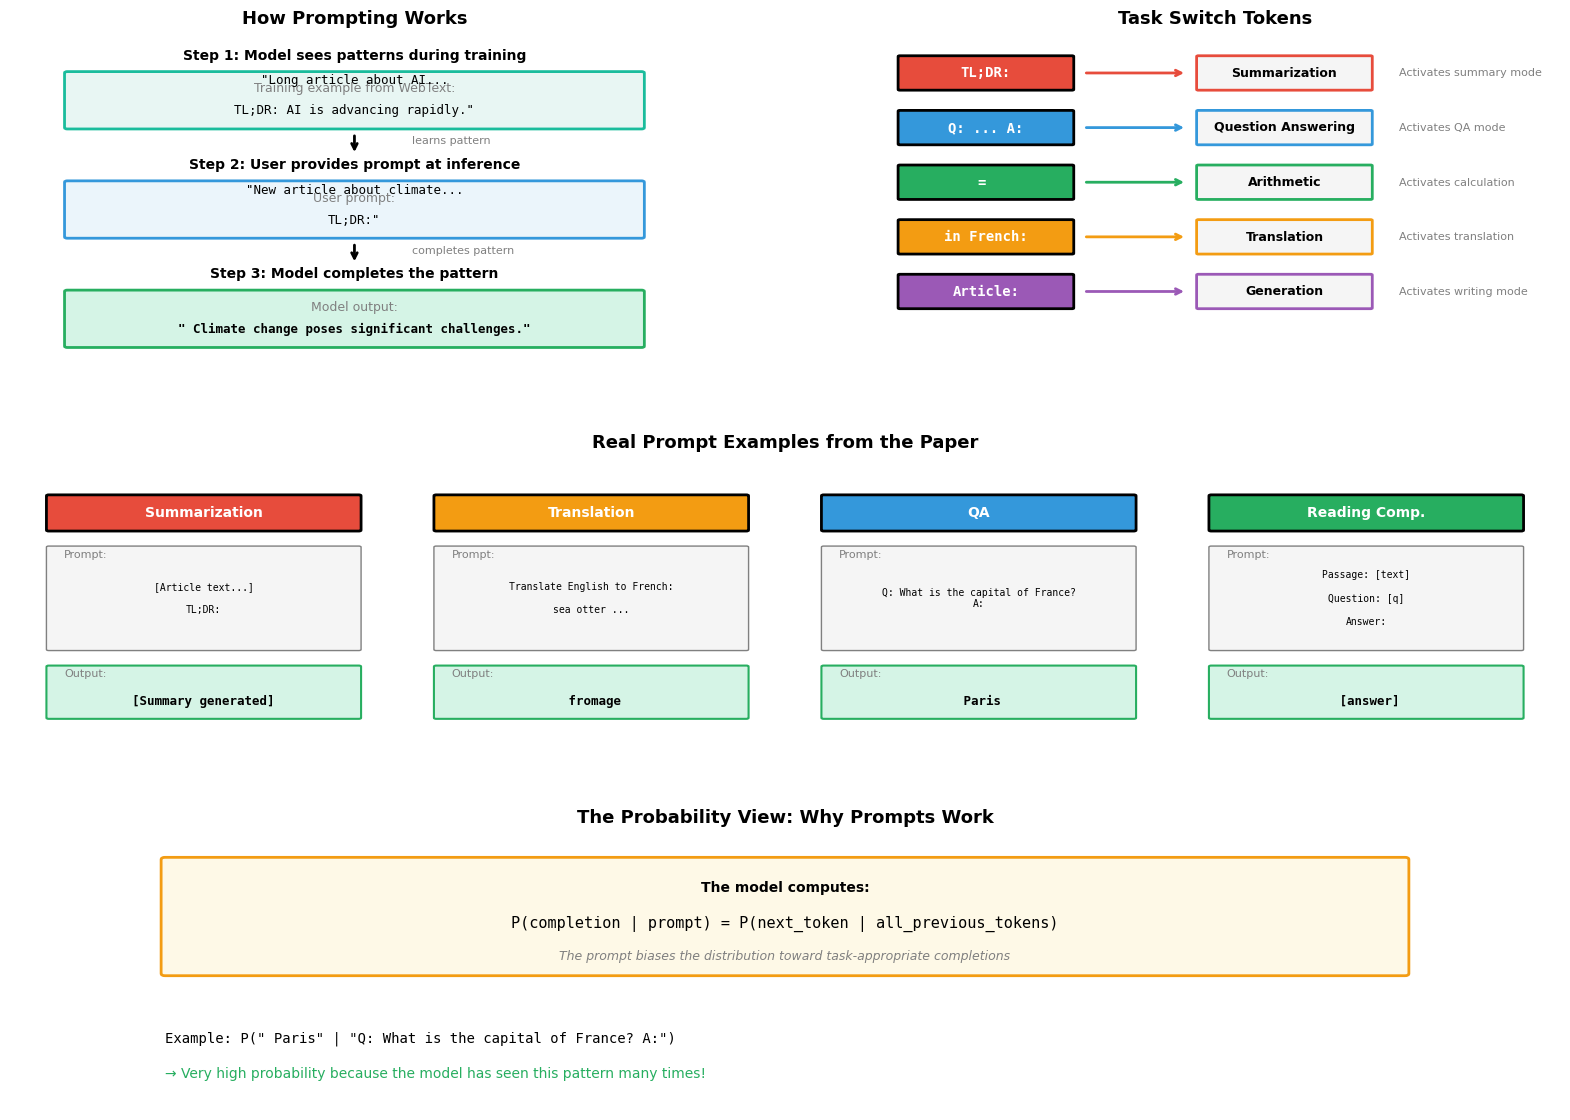

In [3]:
def visualize_prompting_mechanism():
    """
    Detailed visualization of how prompting works.
    """
    fig = plt.figure(figsize=(20, 14))

    gs = gridspec.GridSpec(3, 2, height_ratios=[1.2, 1, 1], hspace=0.35, wspace=0.25)

    # === TOP LEFT: How Prompting Works ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 12)
    ax1.axis('off')
    ax1.set_title('How Prompting Works', fontsize=13, fontweight='bold')

    # Step 1: Pattern in training data
    ax1.text(6, 11, 'Step 1: Model sees patterns during training', fontsize=10,
             ha='center', fontweight='bold')
    rect1 = FancyBboxPatch((1, 8.5), 10, 2, boxstyle="round,pad=0.05",
                           facecolor='#e8f6f3', edgecolor='#1abc9c', linewidth=2)
    ax1.add_patch(rect1)
    ax1.text(6, 9.8, 'Training example from WebText:', fontsize=9, ha='center', color='gray')
    ax1.text(6, 9, '"Long article about AI...\n\nTL;DR: AI is advancing rapidly."',
             ha='center', fontsize=9, family='monospace')

    ax1.annotate('', xy=(6, 7.5), xytext=(6, 8.3),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax1.text(7, 7.9, 'learns pattern', fontsize=8, color='gray')

    # Step 2: User provides prompt
    ax1.text(6, 7, 'Step 2: User provides prompt at inference', fontsize=10,
             ha='center', fontweight='bold')
    rect2 = FancyBboxPatch((1, 4.5), 10, 2, boxstyle="round,pad=0.05",
                           facecolor='#ebf5fb', edgecolor='#3498db', linewidth=2)
    ax1.add_patch(rect2)
    ax1.text(6, 5.8, 'User prompt:', fontsize=9, ha='center', color='gray')
    ax1.text(6, 5, '"New article about climate...\n\nTL;DR:"',
             ha='center', fontsize=9, family='monospace')

    ax1.annotate('', xy=(6, 3.5), xytext=(6, 4.3),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax1.text(7, 3.9, 'completes pattern', fontsize=8, color='gray')

    # Step 3: Model completes
    ax1.text(6, 3, 'Step 3: Model completes the pattern', fontsize=10,
             ha='center', fontweight='bold')
    rect3 = FancyBboxPatch((1, 0.5), 10, 2, boxstyle="round,pad=0.05",
                           facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax1.add_patch(rect3)
    ax1.text(6, 1.8, 'Model output:', fontsize=9, ha='center', color='gray')
    ax1.text(6, 1, '" Climate change poses significant challenges."',
             ha='center', fontsize=9, family='monospace', fontweight='bold')

    # === TOP RIGHT: Task Switch Tokens ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 12)
    ax2.axis('off')
    ax2.set_title('Task Switch Tokens', fontsize=13, fontweight='bold')

    switches = [
        ('TL;DR:', 'Summarization', '#e74c3c', 'Activates summary mode'),
        ('Q: ... A:', 'Question Answering', '#3498db', 'Activates QA mode'),
        ('= ', 'Arithmetic', '#27ae60', 'Activates calculation'),
        ('in French:', 'Translation', '#f39c12', 'Activates translation'),
        ('Article:', 'Generation', '#9b59b6', 'Activates writing mode'),
    ]

    for i, (token, task, color, desc) in enumerate(switches):
        y = 10.5 - i * 2

        # Token box
        rect = FancyBboxPatch((0.5, y-0.6), 3, 1.2, boxstyle="round,pad=0.03",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax2.add_patch(rect)
        ax2.text(2, y, token, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white', family='monospace')

        # Arrow
        ax2.annotate('', xy=(5.5, y), xytext=(3.7, y),
                    arrowprops=dict(arrowstyle='->', color=color, lw=2))

        # Task box
        rect2 = FancyBboxPatch((5.7, y-0.6), 3, 1.2, boxstyle="round,pad=0.03",
                               facecolor='#f5f5f5', edgecolor=color, linewidth=2)
        ax2.add_patch(rect2)
        ax2.text(7.2, y, task, ha='center', va='center', fontsize=9, fontweight='bold')

        # Description
        ax2.text(9.2, y, desc, fontsize=8, va='center', color='gray')

    # === MIDDLE: Prompt Examples ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 8)
    ax3.axis('off')
    ax3.set_title('Real Prompt Examples from the Paper', fontsize=13, fontweight='bold', pad=10)

    examples = [
        ('Summarization',
         '[Article text...]\n\nTL;DR:',
         '[Summary generated]',
         '#e74c3c'),
        ('Translation',
         'Translate English to French:\n\nsea otter => loutre de mer\ncheese =>',
         ' fromage',
         '#f39c12'),
        ('QA',
         'Q: What is the capital of France?\nA:',
         ' Paris',
         '#3498db'),
        ('Reading Comp.',
         'Passage: [text]\n\nQuestion: [q]\n\nAnswer:',
         ' [answer]',
         '#27ae60'),
    ]

    for i, (task, prompt, output, color) in enumerate(examples):
        x = 0.5 + i * 5

        # Task label
        rect = FancyBboxPatch((x, 6), 4, 1, boxstyle="round,pad=0.03",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax3.add_patch(rect)
        ax3.text(x+2, 6.5, task, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')

        # Prompt
        rect2 = FancyBboxPatch((x, 2.5), 4, 3, boxstyle="round,pad=0.03",
                               facecolor='#f5f5f5', edgecolor='gray', linewidth=1)
        ax3.add_patch(rect2)
        ax3.text(x+0.2, 5.2, 'Prompt:', fontsize=8, color='gray')
        # Truncate prompt for display
        prompt_short = prompt[:40] + '...' if len(prompt) > 40 else prompt
        ax3.text(x+2, 4, prompt_short, ha='center', va='center',
                fontsize=7, family='monospace')

        # Output
        rect3 = FancyBboxPatch((x, 0.5), 4, 1.5, boxstyle="round,pad=0.03",
                               facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=1.5)
        ax3.add_patch(rect3)
        ax3.text(x+0.2, 1.7, 'Output:', fontsize=8, color='gray')
        ax3.text(x+2, 1, output, ha='center', va='center',
                fontsize=9, family='monospace', fontweight='bold')

    # === BOTTOM: The Probability View ===
    ax4 = fig.add_subplot(gs[2, :])
    ax4.set_xlim(0, 20)
    ax4.set_ylim(0, 6)
    ax4.axis('off')
    ax4.set_title('The Probability View: Why Prompts Work', fontsize=13, fontweight='bold', pad=10)

    # Equation
    rect_eq = FancyBboxPatch((2, 3), 16, 2.5, boxstyle="round,pad=0.05",
                              facecolor='#fef9e7', edgecolor='#f39c12', linewidth=2)
    ax4.add_patch(rect_eq)

    ax4.text(10, 4.8, 'The model computes:', fontsize=10, ha='center', fontweight='bold')
    ax4.text(10, 4, 'P(completion | prompt) = P(next_token | all_previous_tokens)',
             ha='center', fontsize=11, family='monospace')
    ax4.text(10, 3.3, 'The prompt biases the distribution toward task-appropriate completions',
             ha='center', fontsize=9, color='gray', style='italic')

    # Example
    ax4.text(2, 1.5, 'Example: P(" Paris" | "Q: What is the capital of France? A:")',
             fontsize=10, family='monospace')
    ax4.text(2, 0.7, '→ Very high probability because the model has seen this pattern many times!',
             fontsize=10, color='#27ae60')

    plt.tight_layout()
    plt.show()

visualize_prompting_mechanism()

---

## 3. Every Task GPT-2 Was Tested On

The paper evaluated GPT-2 on **8 different tasks** in the zero-shot setting. Let's examine each one in detail.

### 3.1 Language Modeling (Primary Task)

This is what GPT-2 was actually trained for.

From the paper:

> *"GPT-2 achieves state of the art results on 7 out of 8 tested language modeling datasets in a zero-shot setting."*

| Dataset | Previous SOTA | GPT-2 Small | GPT-2 XL | Improvement |
|---------|--------------|-------------|----------|-------------|
| Penn Treebank | 46.54 | 65.85 | **35.76** | 23% |
| WikiText-2 | 39.14 | 29.41 | **18.34** | 53% |
| WikiText-103 | 18.34 | 22.05 | **17.48** | 5% |
| LAMBADA | 99.8 | 45.99 | **8.63** | 91% |
| CBT-CN | 85.8 | 87.65 | **93.30** | 9% |

(Lower perplexity = better, except CBT which is accuracy)

### 3.2 Children's Book Test (CBT)

Tests understanding of named entities in stories.

From the paper:

> *"Following the LM approach of using the language model to assign a probability to each choice and predict the one with the highest probability, GPT-2 achieves new state of the art results of 93.3% on common nouns and 89.1% on named entities."*

### 3.3 LAMBADA

Tests long-range dependencies - predicting a word that requires understanding 50+ words of context.

From the paper:

> *"GPT-2 improves the state of the art on LAMBADA from 99.8 to 8.63 perplexity and increases the accuracy of correctly predicted final words from 19% to 52.66%."*

### 3.4 Reading Comprehension (CoQA)

From the paper:

> *"When conditioned on a document, questions about that document, and answers to previous questions, GPT-2 achieves 55 F1 on the CoQA test set."*

### 3.5 Summarization

From the paper:

> *"To induce summarization behavior we add the text TL;DR: after the article and generate 100 tokens."*

### 3.6 Translation

From the paper:

> *"On the WMT-14 English-French test set, GPT-2 gets 5 BLEU, which is slightly worse than a word-by-word substitution with a bilingual lexicon."*

Not great, but remember: **zero training on translation data!**

### 3.7 Question Answering (Natural Questions)

From the paper:

> *"The smallest GPT-2 model can answer 4.1% of questions correctly... GPT-2 3x matches the performance of an open-domain QA system which used information retrieval."*

/tmp/ipython-input-3808162110.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


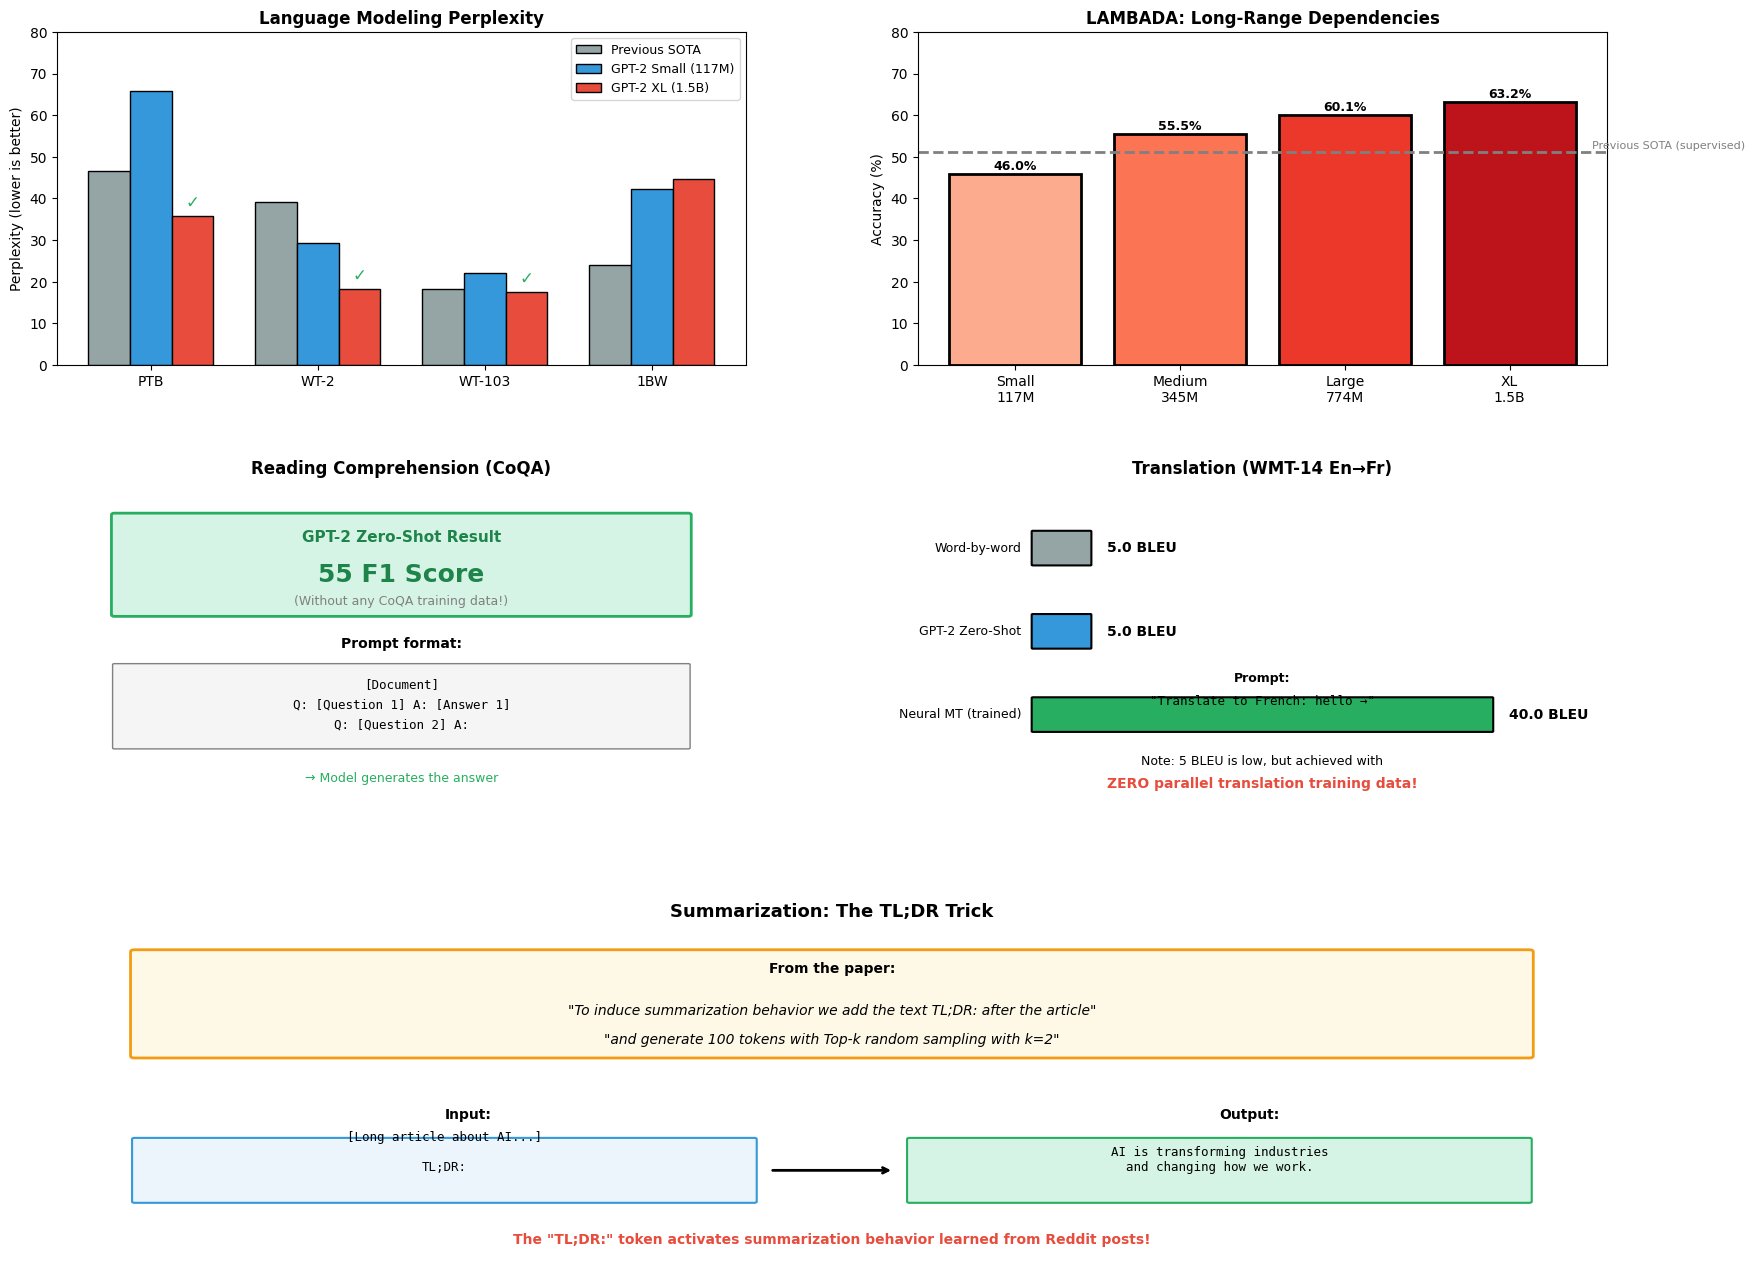

In [4]:
def visualize_all_tasks():
    """
    Comprehensive visualization of all tasks GPT-2 was tested on.
    """
    fig = plt.figure(figsize=(20, 16))

    gs = gridspec.GridSpec(3, 2, hspace=0.35, wspace=0.25)

    # === TOP LEFT: Language Modeling Results ===
    ax1 = fig.add_subplot(gs[0, 0])

    datasets = ['PTB', 'WT-2', 'WT-103', '1BW']
    prev_sota = [46.54, 39.14, 18.34, 24.0]
    gpt2_small = [65.85, 29.41, 22.05, 42.16]
    gpt2_xl = [35.76, 18.34, 17.48, 44.575]

    x = np.arange(len(datasets))
    width = 0.25

    bars1 = ax1.bar(x - width, prev_sota, width, label='Previous SOTA', color='#95a5a6', edgecolor='black')
    bars2 = ax1.bar(x, gpt2_small, width, label='GPT-2 Small (117M)', color='#3498db', edgecolor='black')
    bars3 = ax1.bar(x + width, gpt2_xl, width, label='GPT-2 XL (1.5B)', color='#e74c3c', edgecolor='black')

    ax1.set_ylabel('Perplexity (lower is better)', fontsize=10)
    ax1.set_title('Language Modeling Perplexity', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets)
    ax1.legend(fontsize=9)
    ax1.set_ylim(0, 80)

    # Mark wins
    for i, (p, g) in enumerate(zip(prev_sota, gpt2_xl)):
        if g < p:
            ax1.annotate('✓', xy=(i+width, g+2), ha='center', fontsize=12, color='#27ae60', fontweight='bold')

    # === TOP RIGHT: LAMBADA Deep Dive ===
    ax2 = fig.add_subplot(gs[0, 1])

    models = ['Small\n117M', 'Medium\n345M', 'Large\n774M', 'XL\n1.5B']
    lambada_acc = [45.99, 55.48, 60.12, 63.24]
    lambada_ppl = [45.99, 22.06, 11.59, 8.63]  # Perplexity

    colors = plt.cm.Reds(np.linspace(0.3, 0.8, 4))
    bars = ax2.bar(models, lambada_acc, color=colors, edgecolor='black', linewidth=2)

    ax2.set_ylabel('Accuracy (%)', fontsize=10)
    ax2.set_title('LAMBADA: Long-Range Dependencies', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 80)

    # Previous SOTA
    ax2.axhline(y=51.21, color='gray', linestyle='--', linewidth=2)
    ax2.text(3.5, 52, 'Previous SOTA (supervised)', fontsize=8, color='gray')

    for bar, acc in zip(bars, lambada_acc):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', fontsize=9, fontweight='bold')

    # === MIDDLE LEFT: Reading Comprehension ===
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_xlim(0, 12)
    ax3.set_ylim(0, 10)
    ax3.axis('off')
    ax3.set_title('Reading Comprehension (CoQA)', fontsize=12, fontweight='bold')

    # Result
    rect = FancyBboxPatch((1, 6), 10, 3, boxstyle="round,pad=0.05",
                          facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax3.add_patch(rect)
    ax3.text(6, 8.2, 'GPT-2 Zero-Shot Result', fontsize=11, ha='center', fontweight='bold', color='#1e8449')
    ax3.text(6, 7, '55 F1 Score', fontsize=18, ha='center', fontweight='bold', color='#1e8449')
    ax3.text(6, 6.3, '(Without any CoQA training data!)', fontsize=9, ha='center', color='gray')

    # Context
    ax3.text(6, 5, 'Prompt format:', fontsize=10, ha='center', fontweight='bold')
    rect2 = FancyBboxPatch((1, 2), 10, 2.5, boxstyle="round,pad=0.03",
                           facecolor='#f5f5f5', edgecolor='gray', linewidth=1)
    ax3.add_patch(rect2)
    ax3.text(6, 3.8, '[Document]', ha='center', fontsize=9, family='monospace')
    ax3.text(6, 3.2, 'Q: [Question 1] A: [Answer 1]', ha='center', fontsize=9, family='monospace')
    ax3.text(6, 2.6, 'Q: [Question 2] A:', ha='center', fontsize=9, family='monospace')

    ax3.text(6, 1, '→ Model generates the answer', fontsize=9, ha='center', color='#27ae60')

    # === MIDDLE RIGHT: Translation ===
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_xlim(0, 12)
    ax4.set_ylim(0, 10)
    ax4.axis('off')
    ax4.set_title('Translation (WMT-14 En→Fr)', fontsize=12, fontweight='bold')

    # Results comparison
    systems = [
        ('Word-by-word', 5.0, '#95a5a6'),
        ('GPT-2 Zero-Shot', 5.0, '#3498db'),
        ('Neural MT (trained)', 40.0, '#27ae60'),
    ]

    for i, (name, bleu, color) in enumerate(systems):
        y = 8 - i * 2.5
        width = bleu / 5  # Scale for visualization
        rect = FancyBboxPatch((2, y-0.5), width, 1, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=1.5)
        ax4.add_patch(rect)
        ax4.text(1.8, y, name, ha='right', va='center', fontsize=9)
        ax4.text(2 + width + 0.3, y, f'{bleu} BLEU', va='center', fontsize=10, fontweight='bold')

    ax4.text(6, 1.5, 'Note: 5 BLEU is low, but achieved with', ha='center', fontsize=9)
    ax4.text(6, 0.8, 'ZERO parallel translation training data!', ha='center', fontsize=10,
             fontweight='bold', color='#e74c3c')

    # Translation prompt
    ax4.text(6, 4, 'Prompt:', fontsize=9, ha='center', fontweight='bold')
    ax4.text(6, 3.3, '"Translate to French: hello →"', ha='center', fontsize=9, family='monospace')

    # === BOTTOM: Summarization ===
    ax5 = fig.add_subplot(gs[2, :])
    ax5.set_xlim(0, 20)
    ax5.set_ylim(0, 8)
    ax5.axis('off')
    ax5.set_title('Summarization: The TL;DR Trick', fontsize=13, fontweight='bold', pad=10)

    # From paper quote
    rect_quote = FancyBboxPatch((1, 5), 18, 2.5, boxstyle="round,pad=0.05",
                                 facecolor='#fef9e7', edgecolor='#f39c12', linewidth=2)
    ax5.add_patch(rect_quote)
    ax5.text(10, 7, 'From the paper:', fontsize=10, ha='center', fontweight='bold')
    ax5.text(10, 6, '"To induce summarization behavior we add the text TL;DR: after the article"',
             ha='center', fontsize=10, style='italic')
    ax5.text(10, 5.3, '"and generate 100 tokens with Top-k random sampling with k=2"',
             ha='center', fontsize=10, style='italic')

    # Example
    ax5.text(5, 3.5, 'Input:', fontsize=10, fontweight='bold')
    rect_in = FancyBboxPatch((1, 1.5), 8, 1.5, boxstyle="round,pad=0.03",
                              facecolor='#ebf5fb', edgecolor='#3498db', linewidth=1.5)
    ax5.add_patch(rect_in)
    ax5.text(5, 2.25, '[Long article about AI...]\n\nTL;DR:', ha='center',
             fontsize=9, family='monospace')

    ax5.text(15, 3.5, 'Output:', fontsize=10, fontweight='bold')
    rect_out = FancyBboxPatch((11, 1.5), 8, 1.5, boxstyle="round,pad=0.03",
                               facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=1.5)
    ax5.add_patch(rect_out)
    ax5.text(15, 2.25, 'AI is transforming industries\nand changing how we work.', ha='center',
             fontsize=9, family='monospace')

    ax5.annotate('', xy=(10.8, 2.25), xytext=(9.2, 2.25),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

    ax5.text(10, 0.5, 'The "TL;DR:" token activates summarization behavior learned from Reddit posts!',
             ha='center', fontsize=10, color='#e74c3c', fontweight='bold')

    plt.tight_layout()
    plt.show()

visualize_all_tasks()

In [5]:
def print_detailed_results():
    """
    Print all results from the paper in detail.
    """
    print("=" * 80)
    print("GPT-2 ZERO-SHOT RESULTS (From the Paper)")
    print("=" * 80)

    print("\n[LANGUAGE MODELING - Perplexity (lower is better)]")
    print("-" * 80)
    print(f"{'Dataset':<20} {'Previous SOTA':<15} {'GPT-2 117M':<15} {'GPT-2 1.5B':<15} {'Winner'}")
    print("-" * 80)

    lm_results = [
        ('Penn Treebank', 46.54, 65.85, 35.76, 'GPT-2'),
        ('WikiText-2', 39.14, 29.41, 18.34, 'GPT-2'),
        ('WikiText-103', 18.34, 22.05, 17.48, 'GPT-2'),
        ('1 Billion Word', 24.0, 42.16, 44.575, 'Previous'),
        ('LAMBADA', 99.8, 45.99, 8.63, 'GPT-2'),
    ]

    for dataset, prev, small, xl, winner in lm_results:
        marker = '✓' if winner == 'GPT-2' else ''
        print(f"{dataset:<20} {prev:<15.2f} {small:<15.2f} {xl:<15.2f} {winner} {marker}")

    print("\n[LAMBADA - Word Prediction Accuracy (higher is better)]")
    print("-" * 80)
    print(f"Previous SOTA (supervised):  51.21%")
    print(f"GPT-2 117M (zero-shot):      45.99%")
    print(f"GPT-2 345M (zero-shot):      55.48%")
    print(f"GPT-2 762M (zero-shot):      60.12%")
    print(f"GPT-2 1.5B (zero-shot):      63.24% ← NEW SOTA!")

    print("\n[CHILDREN'S BOOK TEST - Accuracy (higher is better)]")
    print("-" * 80)
    print(f"                             Common Nouns    Named Entities")
    print(f"Previous SOTA:               85.8%          84.2%")
    print(f"GPT-2 1.5B (zero-shot):      93.3%          89.1% ← NEW SOTA!")

    print("\n[READING COMPREHENSION - CoQA F1 Score]")
    print("-" * 80)
    print(f"GPT-2 1.5B (zero-shot): 55 F1")
    print(f"Comparison: Matches 4 out of 7 domain-specific baselines")

    print("\n[TRANSLATION - WMT-14 En→Fr BLEU Score]")
    print("-" * 80)
    print(f"Word-by-word substitution:   5.0 BLEU")
    print(f"GPT-2 1.5B (zero-shot):      5.0 BLEU")
    print(f"State-of-the-art NMT:       ~40 BLEU")
    print(f"Note: Zero parallel data used for training!")

    print("\n[QUESTION ANSWERING - Natural Questions]")
    print("-" * 80)
    print(f"GPT-2 117M:  4.1% exact match")
    print(f"GPT-2 1.5B:  ~5.3% exact match")
    print(f"Note: Competitive with retrieval-based QA systems!")

    print("\n" + "=" * 80)
    print("SUMMARY: GPT-2 achieved state-of-the-art on 7/8 language modeling datasets")
    print("         WITHOUT any task-specific training!")
    print("=" * 80)

print_detailed_results()

GPT-2 ZERO-SHOT RESULTS (From the Paper)

[LANGUAGE MODELING - Perplexity (lower is better)]
--------------------------------------------------------------------------------
Dataset              Previous SOTA   GPT-2 117M      GPT-2 1.5B      Winner
--------------------------------------------------------------------------------
Penn Treebank        46.54           65.85           35.76           GPT-2 ✓
WikiText-2           39.14           29.41           18.34           GPT-2 ✓
WikiText-103         18.34           22.05           17.48           GPT-2 ✓
1 Billion Word       24.00           42.16           44.58           Previous 
LAMBADA              99.80           45.99           8.63            GPT-2 ✓

[LAMBADA - Word Prediction Accuracy (higher is better)]
--------------------------------------------------------------------------------
Previous SOTA (supervised):  51.21%
GPT-2 117M (zero-shot):      45.99%
GPT-2 345M (zero-shot):      55.48%
GPT-2 762M (zero-shot):      60.12%


---

## 4. Why Zero-Shot Works: The Deep Theory

### 4.1 The Compression Argument

There's a deep theoretical reason why language modeling leads to task abilities:

**Compression requires understanding.**

To predict the next word with minimum error (maximum compression), the model must:
1. Understand syntax
2. Understand semantics
3. Understand world knowledge
4. Understand task patterns
5. Understand reasoning

### 4.2 The Mathematical View

Consider the cross-entropy loss:

$$\mathcal{L} = -\mathbb{E}_{x \sim \text{data}}[\log P_{\theta}(x)]$$

Minimizing this is equivalent to **minimizing the KL divergence** between the model and the true data distribution:

$$D_{KL}(P_{\text{data}} || P_{\theta}) = H(P_{\text{data}}) + \mathcal{L}$$

As loss → 0, the model distribution → data distribution.

### 4.3 The Task Emergence Theory

If the training data contains examples of tasks:

```
"The capital of France is Paris."
"Q: What is the capital of Germany? A: Berlin."
```

Then to minimize loss, the model must learn:
- P("Paris" | "The capital of France is") ≈ 1
- P("Berlin" | "Q: What is the capital of Germany? A:") ≈ 1

This **implicitly** teaches the model the QA task!

### 4.4 The Paper's Explanation

From the paper:

> *"A language model can also, in principle, learn p(output|input, task) without any explicit supervision given that the task, input, and output are all sequences of natural language."*

The key insight: **tasks ARE language patterns**.

/tmp/ipython-input-407181748.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


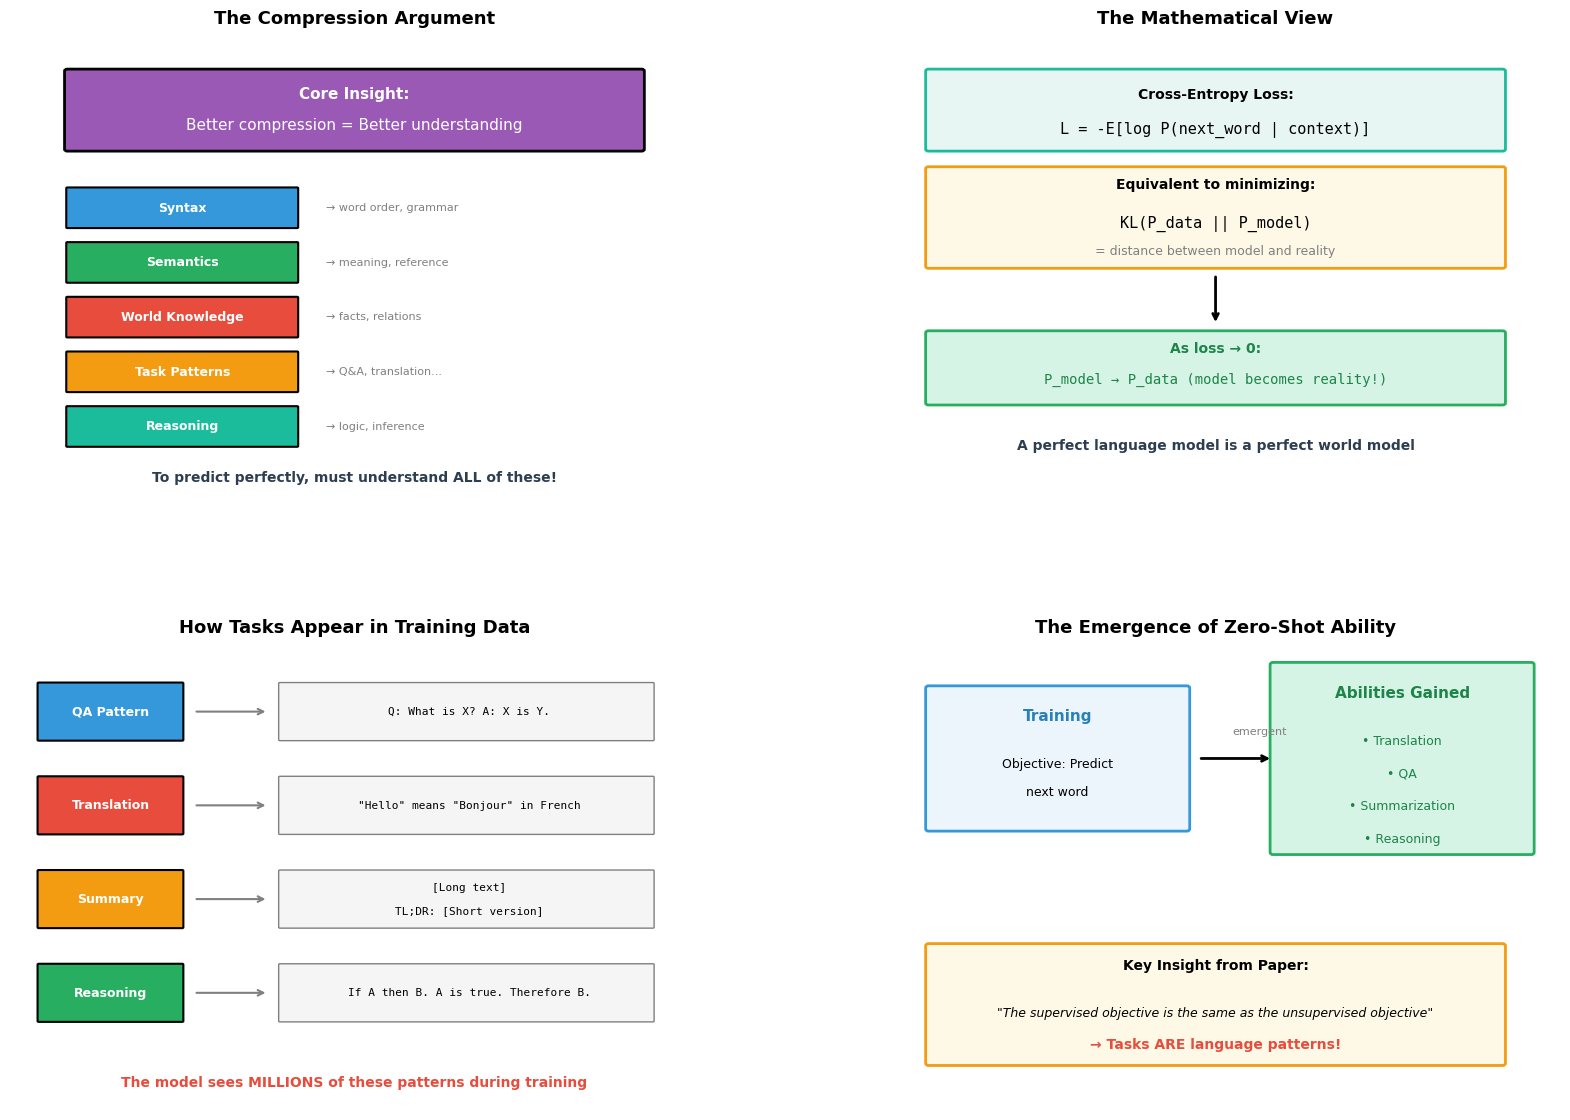

In [6]:
def visualize_why_zero_shot_works():
    """
    Visualize the theoretical basis for zero-shot learning.
    """
    fig = plt.figure(figsize=(20, 14))

    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.25)

    # === TOP LEFT: The Compression Argument ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 12)
    ax1.axis('off')
    ax1.set_title('The Compression Argument', fontsize=13, fontweight='bold')

    # Central thesis
    rect = FancyBboxPatch((1, 9), 10, 2, boxstyle="round,pad=0.05",
                          facecolor='#9b59b6', edgecolor='black', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(6, 10.3, 'Core Insight:', fontsize=11, ha='center', fontweight='bold', color='white')
    ax1.text(6, 9.5, 'Better compression = Better understanding',
             fontsize=11, ha='center', color='white')

    # What understanding means
    components = [
        ('Syntax', '#3498db', 'word order, grammar'),
        ('Semantics', '#27ae60', 'meaning, reference'),
        ('World Knowledge', '#e74c3c', 'facts, relations'),
        ('Task Patterns', '#f39c12', 'Q&A, translation...'),
        ('Reasoning', '#1abc9c', 'logic, inference'),
    ]

    for i, (name, color, desc) in enumerate(components):
        y = 7.5 - i * 1.4
        rect = FancyBboxPatch((1, y-0.5), 4, 1, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=1.5)
        ax1.add_patch(rect)
        ax1.text(3, y, name, ha='center', va='center', fontsize=9,
                fontweight='bold', color='white')
        ax1.text(5.5, y, f'→ {desc}', va='center', fontsize=8, color='gray')

    ax1.text(6, 0.5, 'To predict perfectly, must understand ALL of these!',
             ha='center', fontsize=10, fontweight='bold', color='#2c3e50')

    # === TOP RIGHT: The Mathematical View ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 12)
    ax2.axis('off')
    ax2.set_title('The Mathematical View', fontsize=13, fontweight='bold')

    # Loss equation
    rect1 = FancyBboxPatch((1, 9), 10, 2, boxstyle="round,pad=0.05",
                           facecolor='#e8f6f3', edgecolor='#1abc9c', linewidth=2)
    ax2.add_patch(rect1)
    ax2.text(6, 10.3, 'Cross-Entropy Loss:', fontsize=10, ha='center', fontweight='bold')
    ax2.text(6, 9.4, 'L = -E[log P(next_word | context)]', fontsize=11,
             ha='center', family='monospace')

    # KL divergence
    rect2 = FancyBboxPatch((1, 6), 10, 2.5, boxstyle="round,pad=0.05",
                           facecolor='#fef9e7', edgecolor='#f39c12', linewidth=2)
    ax2.add_patch(rect2)
    ax2.text(6, 8, 'Equivalent to minimizing:', fontsize=10, ha='center', fontweight='bold')
    ax2.text(6, 7, 'KL(P_data || P_model)', fontsize=11, ha='center', family='monospace')
    ax2.text(6, 6.3, '= distance between model and reality', fontsize=9, ha='center', color='gray')

    # Implication
    ax2.annotate('', xy=(6, 4.5), xytext=(6, 5.8),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

    rect3 = FancyBboxPatch((1, 2.5), 10, 1.8, boxstyle="round,pad=0.05",
                           facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax2.add_patch(rect3)
    ax2.text(6, 3.8, 'As loss → 0:', fontsize=10, ha='center', fontweight='bold', color='#1e8449')
    ax2.text(6, 3, 'P_model → P_data (model becomes reality!)',
             fontsize=10, ha='center', family='monospace', color='#1e8449')

    ax2.text(6, 1.3, 'A perfect language model is a perfect world model',
             ha='center', fontsize=10, fontweight='bold', color='#2c3e50')

    # === BOTTOM LEFT: Task in Training Data ===
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_xlim(0, 12)
    ax3.set_ylim(0, 10)
    ax3.axis('off')
    ax3.set_title('How Tasks Appear in Training Data', fontsize=13, fontweight='bold')

    examples = [
        ('QA Pattern', 'Q: What is X? A: X is Y.', '#3498db'),
        ('Translation', '"Hello" means "Bonjour" in French', '#e74c3c'),
        ('Summary', '[Long text]\n\nTL;DR: [Short version]', '#f39c12'),
        ('Reasoning', 'If A then B. A is true. Therefore B.', '#27ae60'),
    ]

    for i, (task, pattern, color) in enumerate(examples):
        y = 8.5 - i * 2

        rect = FancyBboxPatch((0.5, y-0.6), 2.5, 1.2, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=1.5)
        ax3.add_patch(rect)
        ax3.text(1.75, y, task, ha='center', va='center', fontsize=9,
                fontweight='bold', color='white')

        ax3.annotate('', xy=(4.5, y), xytext=(3.2, y),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

        rect2 = FancyBboxPatch((4.7, y-0.6), 6.5, 1.2, boxstyle="round,pad=0.02",
                               facecolor='#f5f5f5', edgecolor='gray', linewidth=1)
        ax3.add_patch(rect2)
        ax3.text(8, y, pattern, ha='center', va='center', fontsize=8, family='monospace')

    ax3.text(6, 0.5, 'The model sees MILLIONS of these patterns during training',
             ha='center', fontsize=10, fontweight='bold', color='#e74c3c')

    # === BOTTOM RIGHT: The Emergence ===
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_xlim(0, 12)
    ax4.set_ylim(0, 10)
    ax4.axis('off')
    ax4.set_title('The Emergence of Zero-Shot Ability', fontsize=13, fontweight='bold')

    # Training
    rect_train = FancyBboxPatch((1, 6), 4.5, 3, boxstyle="round,pad=0.05",
                                 facecolor='#ebf5fb', edgecolor='#3498db', linewidth=2)
    ax4.add_patch(rect_train)
    ax4.text(3.25, 8.3, 'Training', fontsize=11, ha='center', fontweight='bold', color='#2980b9')
    ax4.text(3.25, 7.3, 'Objective: Predict', fontsize=9, ha='center')
    ax4.text(3.25, 6.7, 'next word', fontsize=9, ha='center')

    # Emergence
    ax4.annotate('', xy=(7, 7.5), xytext=(5.7, 7.5),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax4.text(6.3, 8, 'emergent', fontsize=8, color='gray', rotation=0)

    rect_emerge = FancyBboxPatch((7, 5.5), 4.5, 4, boxstyle="round,pad=0.05",
                                  facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax4.add_patch(rect_emerge)
    ax4.text(9.25, 8.8, 'Abilities Gained', fontsize=11, ha='center', fontweight='bold', color='#1e8449')

    abilities = ['Translation', 'QA', 'Summarization', 'Reasoning']
    for i, ability in enumerate(abilities):
        ax4.text(9.25, 7.8 - i * 0.7, f'• {ability}', fontsize=9, ha='center', color='#1e8449')

    # Key insight
    rect_key = FancyBboxPatch((1, 1), 10, 2.5, boxstyle="round,pad=0.05",
                               facecolor='#fef9e7', edgecolor='#f39c12', linewidth=2)
    ax4.add_patch(rect_key)
    ax4.text(6, 3, 'Key Insight from Paper:', fontsize=10, ha='center', fontweight='bold')
    ax4.text(6, 2, '"The supervised objective is the same as the unsupervised objective"',
             ha='center', fontsize=9, style='italic')
    ax4.text(6, 1.3, '→ Tasks ARE language patterns!', ha='center', fontsize=10,
             color='#e74c3c', fontweight='bold')

    plt.tight_layout()
    plt.show()

visualize_why_zero_shot_works()

---

## 5. The Scaling Connection

### 5.1 Why Bigger Models Are Better at Zero-Shot

The paper makes a crucial observation:

> *"Performance on many NLP tasks continues to improve with increasing model capacity."*

### 5.2 The Numbers

| Model | Parameters | LAMBADA Acc | CBT-CN Acc | CoQA F1 |
|-------|------------|-------------|------------|--------|
| Small | 117M | 45.99% | 87.65% | ~40 |
| Medium | 345M | 55.48% | 89.77% | ~45 |
| Large | 774M | 60.12% | 92.35% | ~50 |
| XL | 1.5B | 63.24% | 93.30% | 55 |

### 5.3 The Log-Log Relationship

Performance scales as a **power law** with model size:

$$\text{Performance} \propto (\text{Parameters})^{\alpha}$$

This means:
- 10x more parameters → significant improvement
- No plateau in sight
- Predictable returns on investment

### 5.4 Why Scaling Helps Zero-Shot Specifically

1. **More capacity** = More patterns can be memorized
2. **Better generalization** = Patterns can be applied to new contexts
3. **Richer representations** = Finer distinctions between similar patterns
4. **Longer dependencies** = Can track context over more tokens

### 5.5 The Insight That Changed AI

This led directly to:
- GPT-3 (175B) - 100x bigger, remarkable few-shot
- GPT-4 (rumored 1T+) - Even better
- The "scaling hypothesis" becoming mainstream

/tmp/ipython-input-271964556.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


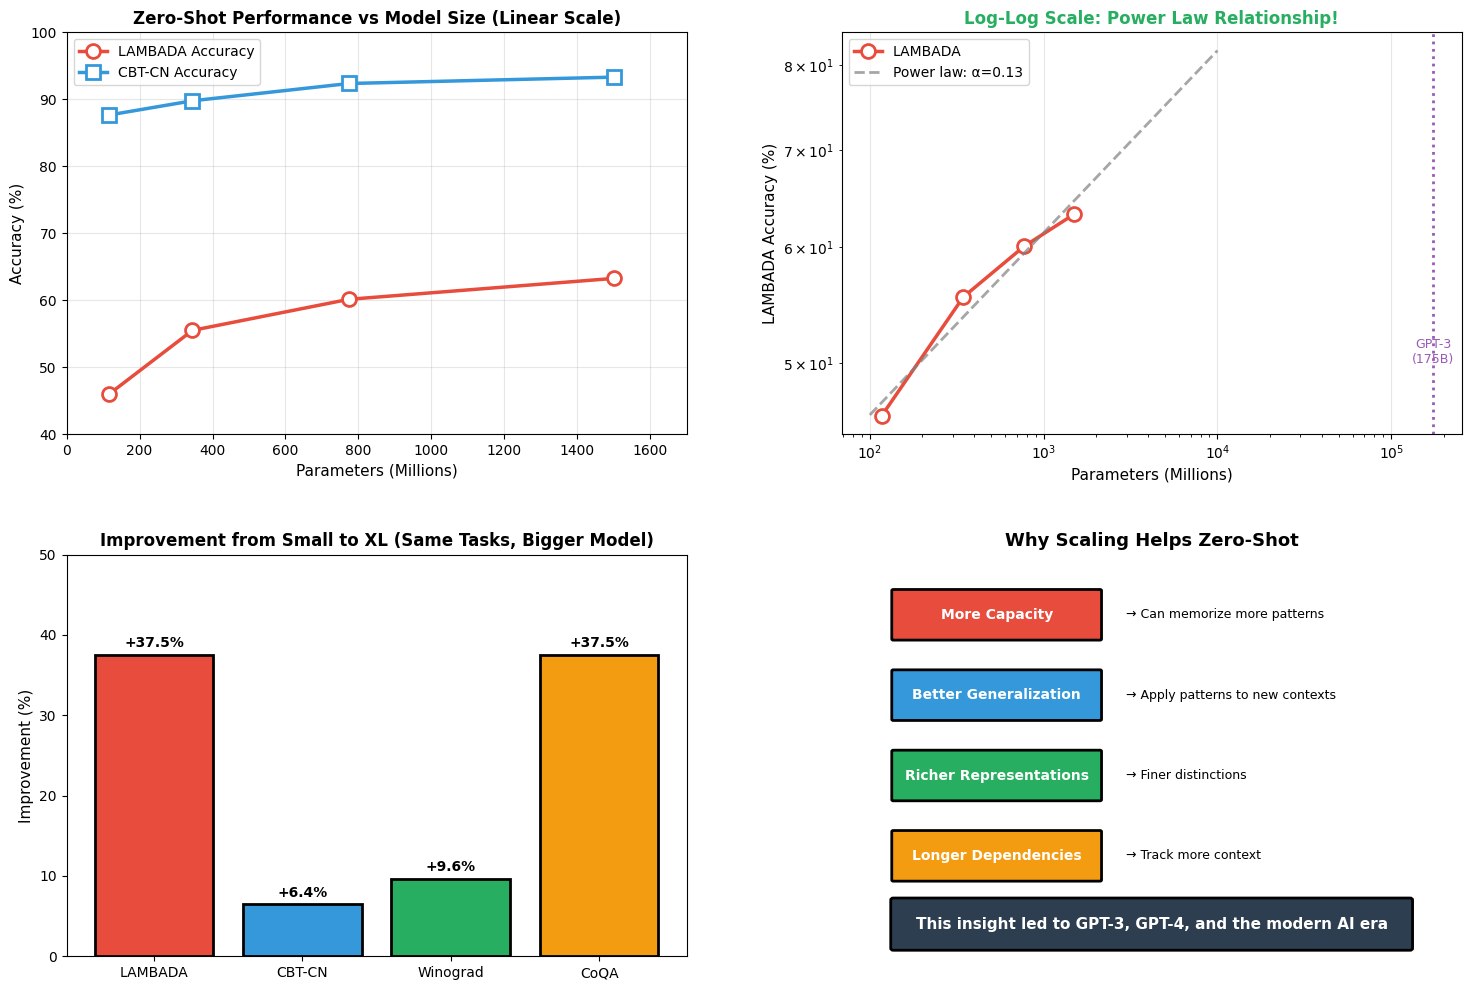

In [7]:
def visualize_scaling_and_zero_shot():
    """
    Visualize how scaling affects zero-shot performance.
    """
    fig = plt.figure(figsize=(18, 12))

    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.25)

    # === TOP LEFT: Linear Scale ===
    ax1 = fig.add_subplot(gs[0, 0])

    params = [117, 345, 774, 1500]
    lambada = [45.99, 55.48, 60.12, 63.24]
    cbt = [87.65, 89.77, 92.35, 93.30]

    ax1.plot(params, lambada, 'o-', color='#e74c3c', linewidth=2.5, markersize=10,
             label='LAMBADA Accuracy', markerfacecolor='white', markeredgewidth=2)
    ax1.plot(params, cbt, 's-', color='#3498db', linewidth=2.5, markersize=10,
             label='CBT-CN Accuracy', markerfacecolor='white', markeredgewidth=2)

    ax1.set_xlabel('Parameters (Millions)', fontsize=11)
    ax1.set_ylabel('Accuracy (%)', fontsize=11)
    ax1.set_title('Zero-Shot Performance vs Model Size (Linear Scale)', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1700)
    ax1.set_ylim(40, 100)

    # === TOP RIGHT: Log-Log Scale ===
    ax2 = fig.add_subplot(gs[0, 1])

    ax2.loglog(params, lambada, 'o-', color='#e74c3c', linewidth=2.5, markersize=10,
               label='LAMBADA', markerfacecolor='white', markeredgewidth=2)

    # Fit line
    log_params = np.log10(params)
    log_lambada = np.log10(lambada)
    coeffs = np.polyfit(log_params, log_lambada, 1)

    fit_params = np.logspace(2, 4, 100)
    fit_lambada = 10 ** (coeffs[0] * np.log10(fit_params) + coeffs[1])
    ax2.loglog(fit_params, fit_lambada, '--', color='gray', linewidth=2, alpha=0.7,
               label=f'Power law: α={coeffs[0]:.2f}')

    ax2.set_xlabel('Parameters (Millions)', fontsize=11)
    ax2.set_ylabel('LAMBADA Accuracy (%)', fontsize=11)
    ax2.set_title('Log-Log Scale: Power Law Relationship!', fontsize=12, fontweight='bold', color='#27ae60')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Extrapolation
    ax2.axvline(x=175000, color='#9b59b6', linestyle=':', linewidth=2)
    ax2.text(175000, 50, 'GPT-3\n(175B)', fontsize=9, ha='center', color='#9b59b6')

    # === BOTTOM LEFT: Task Improvement ===
    ax3 = fig.add_subplot(gs[1, 0])

    tasks = ['LAMBADA', 'CBT-CN', 'Winograd', 'CoQA']
    small = [45.99, 87.65, 64.5, 40]
    xl = [63.24, 93.30, 70.7, 55]
    improvements = [(x-s)/s * 100 for s, x in zip(small, xl)]

    colors = ['#e74c3c', '#3498db', '#27ae60', '#f39c12']
    bars = ax3.bar(tasks, improvements, color=colors, edgecolor='black', linewidth=2)

    ax3.set_ylabel('Improvement (%)', fontsize=11)
    ax3.set_title('Improvement from Small to XL (Same Tasks, Bigger Model)',
                  fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 50)

    for bar, imp in zip(bars, improvements):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'+{imp:.1f}%', ha='center', fontsize=10, fontweight='bold')

    # === BOTTOM RIGHT: The Scaling Story ===
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_xlim(0, 12)
    ax4.set_ylim(0, 10)
    ax4.axis('off')
    ax4.set_title('Why Scaling Helps Zero-Shot', fontsize=13, fontweight='bold')

    reasons = [
        ('More Capacity', 'Can memorize more patterns', '#e74c3c'),
        ('Better Generalization', 'Apply patterns to new contexts', '#3498db'),
        ('Richer Representations', 'Finer distinctions', '#27ae60'),
        ('Longer Dependencies', 'Track more context', '#f39c12'),
    ]

    for i, (reason, desc, color) in enumerate(reasons):
        y = 8.5 - i * 2

        rect = FancyBboxPatch((1, y-0.6), 4, 1.2, boxstyle="round,pad=0.03",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax4.add_patch(rect)
        ax4.text(3, y, reason, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')

        ax4.text(5.5, y, f'→ {desc}', va='center', fontsize=9)

    # The punchline
    rect_punch = FancyBboxPatch((1, 0.2), 10, 1.2, boxstyle="round,pad=0.05",
                                 facecolor='#2c3e50', edgecolor='black', linewidth=2)
    ax4.add_patch(rect_punch)
    ax4.text(6, 0.8, 'This insight led to GPT-3, GPT-4, and the modern AI era',
             ha='center', va='center', fontsize=11, fontweight='bold', color='white')

    plt.tight_layout()
    plt.show()

visualize_scaling_and_zero_shot()

---

## 6. Hands-On: Implementing Zero-Shot Prompting

Let's see how to actually construct prompts for different tasks.

In [8]:
class ZeroShotPromptGenerator:
    """
    Generate zero-shot prompts for various tasks.

    Based on the prompting strategies used in the GPT-2 paper.
    """

    @staticmethod
    def summarization(article: str) -> str:
        """
        Generate a summarization prompt.

        From the paper:
        "To induce summarization behavior we add the text TL;DR: after the article"
        """
        return f"{article}\n\nTL;DR:"

    @staticmethod
    def translation(text: str, source_lang: str = "English", target_lang: str = "French") -> str:
        """
        Generate a translation prompt.

        The paper used example-based prompting for translation.
        """
        # Few examples to establish the pattern (few-shot variant)
        examples = {
            "French": [
                ("sea otter", "loutre de mer"),
                ("cheese", "fromage"),
            ],
            "German": [
                ("sea otter", "Seeotter"),
                ("cheese", "Käse"),
            ],
        }

        prompt = f"Translate {source_lang} to {target_lang}:\n\n"

        if target_lang in examples:
            for src, tgt in examples[target_lang]:
                prompt += f"{src} => {tgt}\n"

        prompt += f"{text} =>"
        return prompt

    @staticmethod
    def question_answering(question: str, context: str = None) -> str:
        """
        Generate a QA prompt.
        """
        if context:
            return f"Context: {context}\n\nQ: {question}\nA:"
        else:
            return f"Q: {question}\nA:"

    @staticmethod
    def reading_comprehension(passage: str, question: str,
                               prev_qa: List[Tuple[str, str]] = None) -> str:
        """
        Generate a reading comprehension prompt (CoQA style).

        From the paper:
        "conditioned on a document, questions about that document,
         and answers to previous questions"
        """
        prompt = f"Passage: {passage}\n\n"

        if prev_qa:
            for q, a in prev_qa:
                prompt += f"Q: {q}\nA: {a}\n\n"

        prompt += f"Q: {question}\nA:"
        return prompt

    @staticmethod
    def arithmetic(expression: str) -> str:
        """
        Generate an arithmetic prompt.
        """
        return f"{expression} ="

    @staticmethod
    def sentiment_analysis(text: str) -> str:
        """
        Generate a sentiment analysis prompt.
        """
        return f"Review: {text}\nSentiment (positive/negative):"

    @staticmethod
    def text_completion(text: str) -> str:
        """
        Simple text completion (the native task).
        """
        return text


# Demonstrate the prompts
generator = ZeroShotPromptGenerator()

print("=" * 70)
print("ZERO-SHOT PROMPT EXAMPLES")
print("=" * 70)

# Summarization
article = """Artificial intelligence has made remarkable progress in recent years.
Deep learning models can now understand language, recognize images, and even
generate creative content. However, concerns about AI safety and ethics remain."""

print("\n[SUMMARIZATION]")
print("-" * 70)
print(generator.summarization(article))
print("\n→ Model generates: [summary here]")

# Translation
print("\n[TRANSLATION]")
print("-" * 70)
print(generator.translation("hello", "English", "French"))
print("\n→ Model generates: bonjour")

# QA
print("\n[QUESTION ANSWERING]")
print("-" * 70)
print(generator.question_answering("What is the capital of France?"))
print("\n→ Model generates: Paris")

# Reading Comprehension
print("\n[READING COMPREHENSION]")
print("-" * 70)
passage = "The Eiffel Tower is located in Paris, France. It was built in 1889."
print(generator.reading_comprehension(
    passage,
    "When was it built?",
    prev_qa=[("Where is the Eiffel Tower?", "In Paris, France")]
))
print("\n→ Model generates: 1889")

# Arithmetic
print("\n[ARITHMETIC]")
print("-" * 70)
print(generator.arithmetic("15 + 27"))
print("\n→ Model generates: 42")

ZERO-SHOT PROMPT EXAMPLES

[SUMMARIZATION]
----------------------------------------------------------------------
Artificial intelligence has made remarkable progress in recent years. 
Deep learning models can now understand language, recognize images, and even 
generate creative content. However, concerns about AI safety and ethics remain.

TL;DR:

→ Model generates: [summary here]

[TRANSLATION]
----------------------------------------------------------------------
Translate English to French:

sea otter => loutre de mer
cheese => fromage
hello =>

→ Model generates: bonjour

[QUESTION ANSWERING]
----------------------------------------------------------------------
Q: What is the capital of France?
A:

→ Model generates: Paris

[READING COMPREHENSION]
----------------------------------------------------------------------
Passage: The Eiffel Tower is located in Paris, France. It was built in 1889.

Q: Where is the Eiffel Tower?
A: In Paris, France

Q: When was it built?
A:

→ Model g

/tmp/ipython-input-1089528824.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


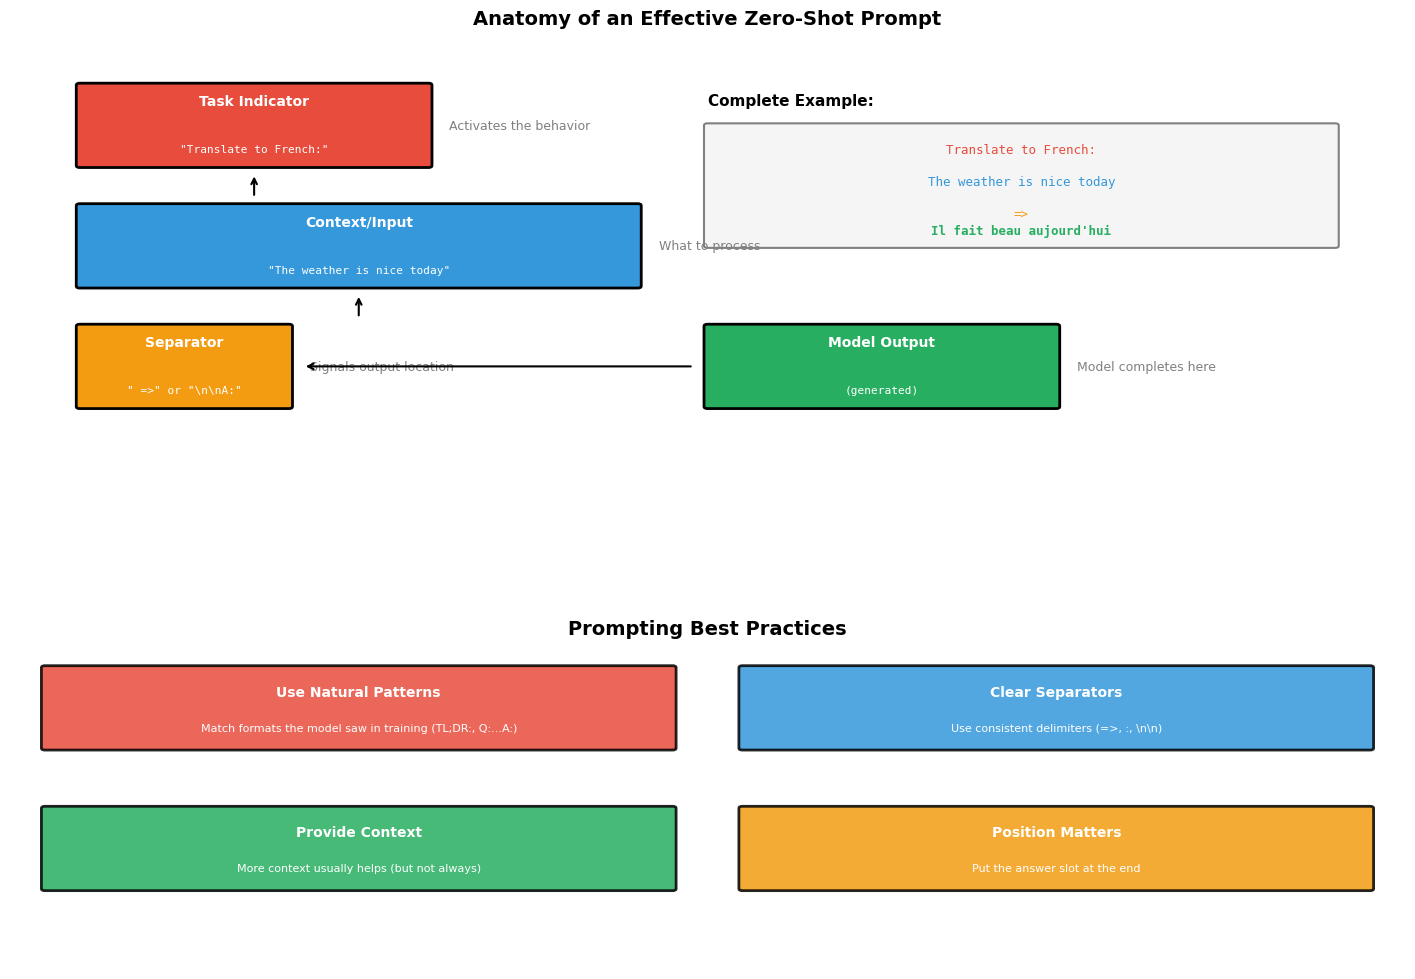

In [9]:
def visualize_prompt_anatomy():
    """
    Visualize the anatomy of an effective prompt.
    """
    fig = plt.figure(figsize=(18, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1], hspace=0.3)

    # === TOP: Prompt Anatomy ===
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlim(0, 20)
    ax1.set_ylim(0, 12)
    ax1.axis('off')
    ax1.set_title('Anatomy of an Effective Zero-Shot Prompt', fontsize=14, fontweight='bold', pad=15)

    # Example prompt breakdown
    prompt_parts = [
        (1, 9, 5, 2, 'Task Indicator', '"Translate to French:"', '#e74c3c',
         'Activates the behavior'),
        (1, 6, 8, 2, 'Context/Input', '"The weather is nice today"', '#3498db',
         'What to process'),
        (1, 3, 3, 2, 'Separator', '" =>" or "\\n\\nA:"', '#f39c12',
         'Signals output location'),
        (10, 3, 5, 2, 'Model Output', '(generated)', '#27ae60',
         'Model completes here'),
    ]

    for x, y, w, h, label, example, color, explanation in prompt_parts:
        rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax1.add_patch(rect)
        ax1.text(x + w/2, y + h - 0.4, label, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')
        ax1.text(x + w/2, y + 0.4, example, ha='center', va='center',
                fontsize=8, color='white', family='monospace')

        # Explanation
        ax1.text(x + w + 0.3, y + h/2, explanation, va='center', fontsize=9, color='gray')

    # Arrows showing flow
    ax1.annotate('', xy=(3.5, 8.8), xytext=(3.5, 8.2),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    ax1.annotate('', xy=(5, 5.8), xytext=(5, 5.2),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    ax1.annotate('', xy=(4.2, 4), xytext=(9.8, 4),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    # Full example
    ax1.text(10, 10.5, 'Complete Example:', fontsize=11, fontweight='bold')
    rect_full = FancyBboxPatch((10, 7), 9, 3, boxstyle="round,pad=0.05",
                                facecolor='#f5f5f5', edgecolor='gray', linewidth=1.5)
    ax1.add_patch(rect_full)
    ax1.text(14.5, 9.3, 'Translate to French:', fontsize=9, ha='center',
             family='monospace', color='#e74c3c')
    ax1.text(14.5, 8.5, 'The weather is nice today', fontsize=9, ha='center',
             family='monospace', color='#3498db')
    ax1.text(14.5, 7.7, '=>', fontsize=9, ha='center',
             family='monospace', color='#f39c12')
    ax1.text(14.5, 7.3, 'Il fait beau aujourd\'hui', fontsize=9, ha='center',
             family='monospace', color='#27ae60', fontweight='bold')

    # === BOTTOM: Prompting Tips ===
    ax2 = fig.add_subplot(gs[1])
    ax2.set_xlim(0, 20)
    ax2.set_ylim(0, 8)
    ax2.axis('off')
    ax2.set_title('Prompting Best Practices', fontsize=14, fontweight='bold', pad=10)

    tips = [
        ('Use Natural Patterns', 'Match formats the model saw in training (TL;DR:, Q:...A:)', '#e74c3c'),
        ('Clear Separators', 'Use consistent delimiters (=>, :, \\n\\n)', '#3498db'),
        ('Provide Context', 'More context usually helps (but not always)', '#27ae60'),
        ('Position Matters', 'Put the answer slot at the end', '#f39c12'),
    ]

    for i, (title, desc, color) in enumerate(tips):
        x = 0.5 + (i % 2) * 10
        y = 5.5 if i < 2 else 2

        rect = FancyBboxPatch((x, y), 9, 2, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2, alpha=0.85)
        ax2.add_patch(rect)
        ax2.text(x + 4.5, y + 1.4, title, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')
        ax2.text(x + 4.5, y + 0.5, desc, ha='center', va='center',
                fontsize=8, color='white')

    plt.tight_layout()
    plt.show()

visualize_prompt_anatomy()

---

## 7. Summary: The Zero-Shot Revolution

### 7.1 Key Takeaways

| Concept | Description |
|---------|-------------|
| **Zero-shot** | Performing tasks without any task-specific training |
| **Prompting** | Using text patterns to activate learned behaviors |
| **Task switches** | Tokens like "TL;DR:" that change model behavior |
| **Emergence** | Tasks abilities appear from language modeling alone |
| **Scaling** | Larger models are better at zero-shot tasks |

### 7.2 Results Summary

- **7/8** language modeling datasets: State-of-the-art
- **LAMBADA**: 63.24% (vs 51.21% supervised SOTA)
- **CBT-CN**: 93.3% (vs 85.8% SOTA)
- **CoQA**: 55 F1 (competitive with baselines)
- **Translation**: 5 BLEU (limited but zero training!)

### 7.3 Why This Matters

Zero-shot learning changed AI research by showing:

1. **Tasks are patterns**: Any task can be expressed as text
2. **Scale unlocks abilities**: Bigger models = more capabilities
3. **One model, many tasks**: No need for task-specific training
4. **Prompting is programming**: Natural language as code

### 7.4 The Path to Modern LLMs

```
GPT-2 Zero-Shot → GPT-3 Few-Shot → ChatGPT RLHF → GPT-4 Multimodal
```

Every major LLM development since has built on these ideas.

---

### What's Next: Part IV - Training & Scaling

We'll cover:
- How WebText was created
- Training infrastructure
- Scaling laws
- Compute requirements

---

## References

1. Radford et al. (2019). [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
2. Brown et al. (2020). [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165) (GPT-3)
3. McCann et al. (2018). [The Natural Language Decathlon](https://arxiv.org/abs/1806.08730)